# Two Sigma Renthop classification challenge

#### By Akshay Kumar Vikram - Master Business Intelligence & Analytics - Stevens Institute Of Tech

## Load data into R

In [1]:
packages <- c("jsonlite", "dplyr", "purrr")
purrr::walk(packages, library, character.only = TRUE, warn.conflicts = FALSE)

train <- fromJSON("training_data/train.json")
test  <- fromJSON('test_data/test.json')

In [2]:
vars <- setdiff(names(test), c("photos", "features"))
test <- map_at(test, vars, unlist) %>% tibble::as_tibble(.)
vars <- setdiff(names(train), c("photos", "features"))
train <- map_at(train, vars, unlist) %>% tibble::as_tibble(.)

## Data Cleaning and Wrangling

### Converting date into a date object

In [3]:
test$created <- as.POSIXct(test$created)
train$created <- as.POSIXct(train$created)

### Add suffix 'NY' to all the street Address

In [4]:
train$street_address <- paste(train$street_address,',NY',sep='')
test$street_address <- paste(test$street_address,',NY',sep='')

## Estimating neighbourhood of each listing

### Loading necessary libraries

In [5]:
library(tigris)
library(dplyr)
library(leaflet)
library(sp)
library(ggmap)
library(maptools)
library(broom)
library(httr)
library(rgdal)


Attaching package: 'tigris'

The following object is masked from 'package:graphics':

    plot

Loading required package: ggplot2
Checking rgeos availability: TRUE
rgdal: version: 1.2-5, (SVN revision 648)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.0.1, released 2015/09/15
 Path to GDAL shared files: F:/Documents/R/win-library/3.3/rgdal/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: F:/Documents/R/win-library/3.3/rgdal/proj
 Linking to sp version: 1.2-4 


### Importing Newyork city neighbourhood data

In [6]:
r <- GET('http://data.beta.nyc//dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson')
nyc_neighborhoods <- readOGR(content(r,'text'), 'OGRGeoJSON', verbose = F)
nyc_neighborhoods_df <- tidy(nyc_neighborhoods)

No encoding supplied: defaulting to UTF-8.
Regions defined for each Polygons


Regions defined for each Polygons
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=40.71,-74&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false


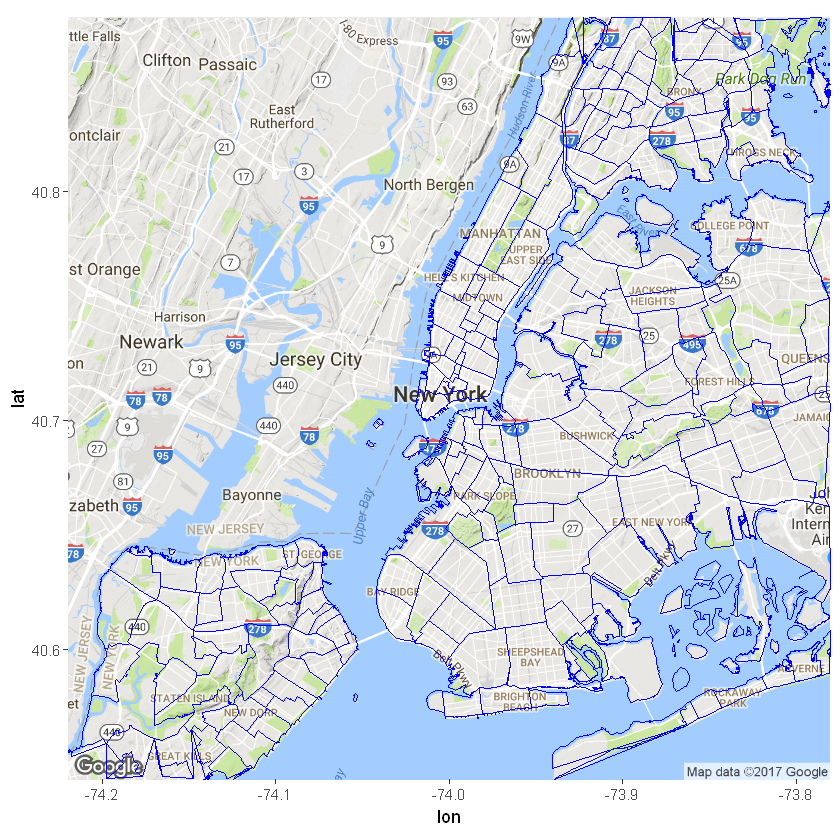

In [7]:
nyc_neighborhoods_df <- tidy(nyc_neighborhoods)
nyc_map <- get_map(location = c(lon = -74.00, lat = 40.71), maptype = "terrain", zoom = 11)
suppressMessages(ggmap(nyc_map)) + 
  geom_polygon(data=nyc_neighborhoods_df, aes(x=long, y=lat, group=group), color="blue", fill=NA)

### Estimation Neighbourhoods and boroughs of training data set

In [8]:
lats <- train$latitude
lngs <- train$longitude
points <- data.frame(lat=as.numeric(lats), lng=as.numeric(lngs))

In [9]:
points_spdf <- points
coordinates(points_spdf) <- ~lng + lat
proj4string(points_spdf) <- proj4string(nyc_neighborhoods)
matches <- over(points_spdf, nyc_neighborhoods)
points <- cbind(points, matches)

In [10]:
head(points)

lat,lng,neighborhood,boroughCode,borough,X.id
40.7108,-73.9539,Williamsburg,4,Brooklyn,http://nyc.pediacities.com/Resource/Neighborhood/Williamsburg
40.7513,-73.9722,Midtown,1,Manhattan,http://nyc.pediacities.com/Resource/Neighborhood/Midtown
40.7575,-73.9625,Midtown,1,Manhattan,http://nyc.pediacities.com/Resource/Neighborhood/Midtown
40.7145,-73.9425,Williamsburg,4,Brooklyn,http://nyc.pediacities.com/Resource/Neighborhood/Williamsburg
40.7439,-73.9743,Kips Bay,1,Manhattan,http://nyc.pediacities.com/Resource/Neighborhood/Kips_Bay
40.7348,-73.9865,Gramercy,1,Manhattan,http://nyc.pediacities.com/Resource/Neighborhood/Gramercy


### Adding Neighborhood and Borough data to the training data

In [11]:
train <- cbind(train,points)

### Similarly for test data set

In [12]:
lats <- test$latitude
lngs <- test$longitude
points <- data.frame(lat=as.numeric(lats), lng=as.numeric(lngs))
points_spdf <- points
coordinates(points_spdf) <- ~lng + lat
proj4string(points_spdf) <- proj4string(nyc_neighborhoods)
matches <- over(points_spdf, nyc_neighborhoods)
points <- cbind(points, matches)
test <- cbind(test,points)

## Fixing errors in co-ordinates

In [13]:
library(ggmap)
fix.cordinates <- function(latitude,longitude,address,neighborhood)
 {

 if (is.na(neighborhood))
 {
    dummy <- data.frame(long=NA,lat=NA)
    dummy[,c("long","lat")] = geocode(address,source = 'google')
    latitude = dummy$lat
    longitude = dummy$long
}
return(c(latitude,longitude))
}

In [14]:
temp <- apply(train[,c("latitude","longitude","street_address","neighborhood")],1,function(x) fix.cordinates(x['latitude'],x['longitude'],x['street_address'],x["neighborhood"]))
train$latitude = temp[1,]
train$longitude = temp[2,]

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=20%20River%20Court,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=32%20Garrison%20Street,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=30%20River%20Court,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=145%2028%20Street,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=270%20Tenth%20Street,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=1844%2084%20Street,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=270%20Tenth%20Street,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=270%20Tenth%20Street,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json

In [15]:
temp <- apply(test[,c("latitude","longitude","street_address","neighborhood")],1,function(x) fix.cordinates(x['latitude'],x['longitude'],x['street_address'],x["neighborhood"]))
test$latitude = temp[1,]
test$longitude = temp[2,]

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=38-05%2052%20Street,NY&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=30%20River%20Court,NY&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=30%20Newport%20Parkway,NY&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=270%20Tenth%20Street,NY&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=163%204th%20ave,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=155%20Washington%20Street,NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=90-92%20Vark%20Street,NY&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=45%20Park%20Lane%20South,NY&sensor=false
.Information from URL : http://maps.googleapis.com/maps

### Removing rows with missing values

In [16]:
train <- train[complete.cases(train[c('latitude','longitude')]),]
test <- test[complete.cases(test[c('latitude','longitude')]),]


### Finding neighbourhoods for updated Co-Ordinates

In [17]:
lats <- train$latitude
lngs <- train$longitude
points <- data.frame(lat=as.numeric(lats), lng=as.numeric(lngs))

In [18]:
points_spdf <- points
coordinates(points_spdf) <- ~lng + lat
proj4string(points_spdf) <- proj4string(nyc_neighborhoods)
matches <- over(points_spdf, nyc_neighborhoods)
points <- cbind(points, matches)

In [19]:
train[,c('lat','lng','neighborhood','boroughCode','borough','X.id')] <- points

In [20]:
lats <- test$latitude
lngs <- test$longitude
points <- data.frame(lat=as.numeric(lats), lng=as.numeric(lngs))
points_spdf <- points
coordinates(points_spdf) <- ~lng + lat
proj4string(points_spdf) <- proj4string(nyc_neighborhoods)
matches <- over(points_spdf, nyc_neighborhoods)
points <- cbind(points, matches)
test[,c('lat','lng','neighborhood','boroughCode','borough','X.id')] <- points

### Note: Around 37 listing in test set and 49 in training set are located outside NYC are seperated for now.

In [21]:
train_outliers <- train[!complete.cases(train['neighborhood']),]
test_outliers <- test[!complete.cases(test['neighborhood']),]


In [22]:
train <- train[complete.cases(train['neighborhood']),]
test <- test[complete.cases(test['neighborhood']),]


## Let's find out how the listings are distributed in NYC

In [23]:
points <- train[c('lat','lng','neighborhood','boroughCode','borough','X.id')]
points_by_neighborhood <- points %>%
  group_by(neighborhood) %>%
  summarize(num_points=n())

map_data <- geo_join(nyc_neighborhoods, points_by_neighborhood, "neighborhood", "neighborhood")

pal <- colorNumeric(palette = "RdBu",
                    domain = range(map_data@data$num_points, na.rm=T))


In [24]:
plot_data <- tidy(nyc_neighborhoods, region="neighborhood") %>%
  left_join(., points_by_neighborhood, by=c("id"="neighborhood")) %>%
  filter(!is.na(num_points))

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
"joining factor and character vector, coercing into character vector"

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=40.71,-74&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false


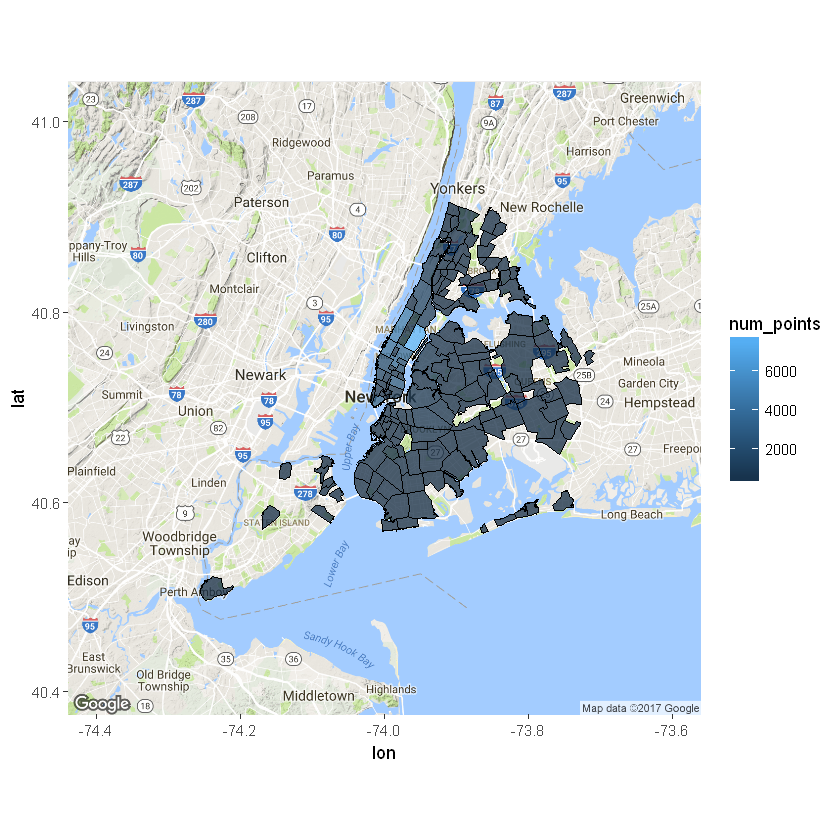

In [25]:
nyc_map <- get_map(location = c(lon = -74.00, lat = 40.71), maptype = "terrain", zoom = 10)
ggmap(nyc_map) + 
  geom_polygon(data=plot_data, aes(x=long, y=lat, group=group, fill=num_points),colour='black', alpha=0.75)